In [1]:
import numpy as np
import pandas as pd

import json 
import requests
import folium

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

print('Libraries imported.')

Libraries imported.


## Download and Clean Postal Data of Toronto

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
toronto_postcode = pd.read_html(url, header=0)
toronto_postcode = toronto_postcode[0]

toronto_postcode.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [3]:
toronto_postcode = toronto_postcode[~(toronto_postcode['Borough']=='Not assigned')]

for i in toronto_postcode.index:
    if (toronto_postcode.loc[i, 'Neighbourhood']=='Not assigned'):
        toronto_postcode.loc[i, 'Neighbourhood'] = toronto_postcode.loc[i, 'Borough']

toronto_postcode = toronto_postcode.groupby(['Postcode']).agg({lambda x: ', '.join(set(x))})

toronto_postcode = toronto_postcode.reset_index()

toronto_postcode.columns = toronto_postcode.columns.droplevel(1)

toronto_postcode.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Morningside, West Hill, Guildwood"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Add Location Data to Each Postal Code

In [4]:
geo_url = 'https://cocl.us/Geospatial_data'
geo_df = pd.read_csv(geo_url)

geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
toronto_postcode = toronto_postcode.merge(geo_df, left_on='Postcode', right_on='Postal Code', how='left')

toronto_postcode.drop(columns=['Postal Code'], inplace=True)

toronto_postcode.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Morningside, West Hill, Guildwood",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Only consider Boroughs containing 'Toronto' in their names

In [6]:
toronto_postcode = toronto_postcode[toronto_postcode['Borough'].str.contains('Toronto')]
toronto_postcode = toronto_postcode.reset_index(drop=True)
toronto_postcode.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [7]:
toronto_postcode.shape

(38, 5)

In [8]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent='tor_explorer')
location = geolocator.geocode(address)
tor_lat = location.latitude
tor_lng = location.longitude
print('The geographical coordinate of Toronto are ({} {}).'.format(tor_lat, tor_lng))

The geographical coordinate of Toronto are (43.653963 -79.387207).


In [9]:
# create a map of Toronto based on its lat, lng
tor_map = folium.Map(location=[tor_lat, tor_lng], zoom_start=11)

# add markers of postal areas to map
for postcode, bor, nei, lat, lng in zip(toronto_postcode['Postcode'], toronto_postcode['Borough'], 
                                        toronto_postcode['Neighbourhood'], toronto_postcode['Latitude'], 
                                        toronto_postcode['Longitude']):
    label = '{}, {}'.format(nei, bor)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(tor_map)
    
tor_map

In [50]:
tor_map.save('tor_map.html')

## Get Top 100 Venues in Each Area and Main Category of Each Venue Using Category Hierachy from Foursquare

In [10]:
CLIENT_ID = 'K0VC3KNOZ3RSEQPEQNHAQDV5MQHDNT2BZKWRQMS1XBGMRPNR' # your Foursquare ID
CLIENT_SECRET = '4QUSP25DL4UFG0IWHKMWFSPBX3XIYBWZ1H4FXM1FJZLZU33Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K0VC3KNOZ3RSEQPEQNHAQDV5MQHDNT2BZKWRQMS1XBGMRPNR
CLIENT_SECRET:4QUSP25DL4UFG0IWHKMWFSPBX3XIYBWZ1H4FXM1FJZLZU33Y


In [11]:
LIMIT = 100

def getNearbyVenues(names, lats, lngs, radius=500):
    
    venues_list = []
    for name, lat, lng in zip(names, lats, lngs):
        
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']

        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                             'Latitude',
                             'Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    
    return(nearby_venues)

In [12]:
toronto_venues = getNearbyVenues(names=toronto_postcode['Postcode'],
                             lats=toronto_postcode['Latitude'],
                             lngs=toronto_postcode['Longitude'])

print('Top 100 venues of all areas are found!')

Top 100 venues of all areas are found!


In [13]:
toronto_venues.head()

,Postcode,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4K,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [14]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
       CLIENT_ID, CLIENT_SECRET, VERSION)

category_hierarchy = requests.get(url).json()

In [15]:
def get_child(categories_list, a):
    if len(categories_list)==0:
        return
    else:
        for i in categories_list:
            a.append(i['name'])
            get_child(i['categories'], a)

def get_categories_dict(c_list):
    c_dict = {}
    
    if len(c_list)==0:
        return None
    
    for c in c_list:
        a = []
        get_child(c['categories'], a)
        c_dict[c['name']] = a
        
    return c_dict 

In [16]:
categories_parent_child = get_categories_dict(category_hierarchy['response']['categories'])

categories_child_parent = {}

for key, value in categories_parent_child.items():
    for v in value:
        categories_child_parent[v] = key

In [17]:
categories_parent_child.keys()

dict_keys(['Arts & Entertainment', 'College & University', 'Event', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Professional & Other Places', 'Residence', 'Shop & Service', 'Travel & Transport'])

In [18]:
toronto_venues['Category'] = toronto_venues['Venue Category']

for i in toronto_venues.index:
    try:
        toronto_venues.loc[i, 'Category'] = categories_child_parent[toronto_venues.loc[i, 'Category']]
    except:
        toronto_venues.loc[i, 'Category'] = toronto_venues.loc[i, 'Category']
    
toronto_venues.head()

,Postcode,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail,Outdoors & Recreation
1,M4E,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,Shop & Service
2,M4E,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub,Nightlife Spot
3,M4E,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood,Outdoors & Recreation
4,M4K,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant,Food


Foursquare divide all venues into 10 main categories:
* Arts & Entertainment
* College & University
* Event
* Food
* Nightlife Spot
* Outdoors & Recreation
* Professional & Other Places
* Residence
* Shop & Service
* Travel & Transport

## Preliminary Data Analysis

In [19]:
top_categories = toronto_venues['Category'].value_counts()
top_categories

Food                           1009
Shop & Service                  251
Nightlife Spot                  149
Outdoors & Recreation           124
Arts & Entertainment             85
Travel & Transport               70
Professional & Other Places      16
College & University              3
Event                             1
Name: Category, dtype: int64

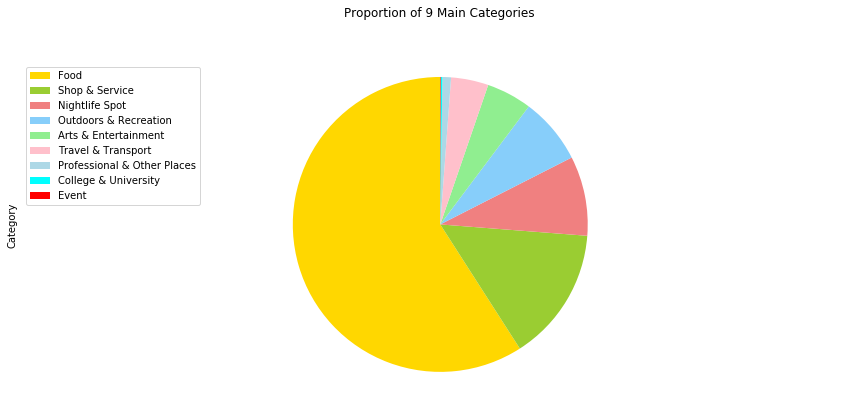

In [20]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'lightblue', 'cyan',
               'red', 'blue']

top_categories[:10].plot(kind='pie', figsize=(15, 6), startangle=90, colors=colors_list,
                     pctdistance=1.2, labels=None)

plt.title('Proportion of 9 Main Categories', y=1.12) 
plt.axis('equal')
plt.legend(labels=top_categories.index[:10], loc='upper left') 
plt.show()

We have 9 main categories in Toronto (no Residence). The top 3 most common categories are *Food*, *Shop & Service* and *Night Spot*. Food consists of over 50 percent. 

In [21]:
top_venues = toronto_venues['Venue Category'].value_counts()
top_venues.head()

Coffee Shop           145
Café                   93
Restaurant             52
Italian Restaurant     46
Bakery                 40
Name: Venue Category, dtype: int64

Text(0.5, 1.0, 'Top 10 Venues Category')

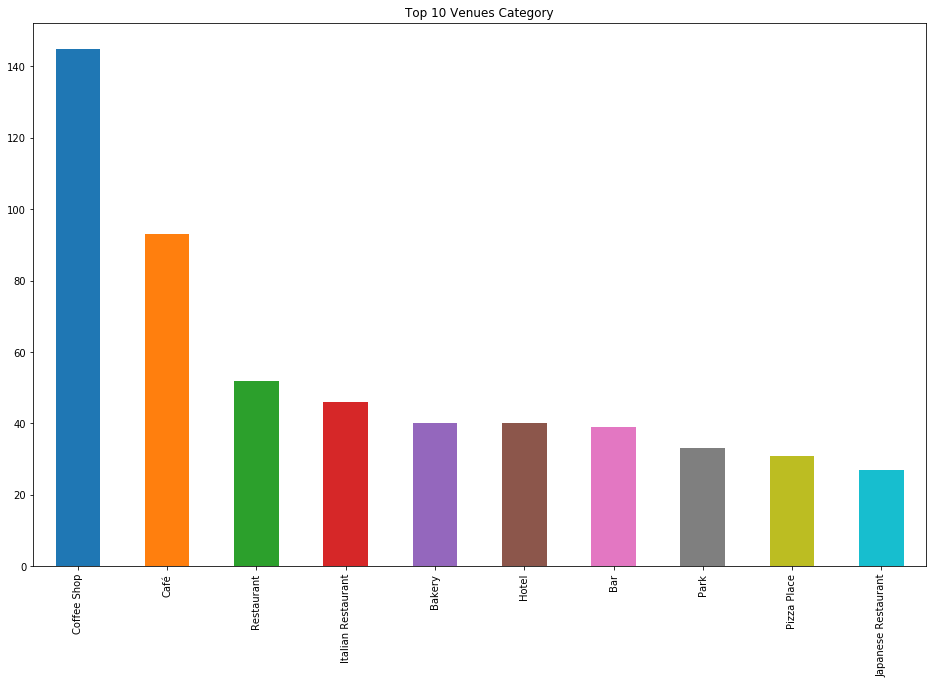

In [22]:
top_venues[:10].plot(kind='bar', figsize=(16, 10))

plt.title('Top 10 Venues Category')

In all venue categories, the most popular ones are Coffee Shop and Café, followed by Restaurant. Except venue categories of food, Hotel and Park are two venue categories very common.

## Split data into two parts: food_venues & other_venues

In [23]:
split_condition = toronto_venues['Category']=='Food'

food_venues = toronto_venues[split_condition]
other_venues = toronto_venues[~split_condition]

In [24]:
food_venues = food_venues.reset_index(drop=True)
food_venues.head()

,Postcode,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category
0,M4K,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant,Food
1,M4K,43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop,Food
2,M4K,43.679557,-79.352188,Mezes,43.677962,-79.350196,Greek Restaurant,Food
3,M4K,43.679557,-79.352188,La Diperie,43.677530,-79.352295,Ice Cream Shop,Food
4,M4K,43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant,Food


In [25]:
other_venues = other_venues.reset_index(drop=True)
other_venues.head()

,Postcode,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail,Outdoors & Recreation
1,M4E,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,Shop & Service
2,M4E,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub,Nightlife Spot
3,M4E,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood,Outdoors & Recreation
4,M4K,43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop,Shop & Service


## Cluster Areas in Toronto Based on Food

Our focus is to research food distribution in Toronto. The following project will only consider all food venues.

In [26]:
top_food_venues = food_venues['Venue Category'].value_counts()
top_food_venues.head()

Coffee Shop           145
Café                   93
Restaurant             52
Italian Restaurant     46
Bakery                 40
Name: Venue Category, dtype: int64

In [52]:
top_food_venues

Coffee Shop                        145
Café                                93
Restaurant                          52
Italian Restaurant                  46
Bakery                              40
Pizza Place                         31
Japanese Restaurant                 27
American Restaurant                 25
Sandwich Place                      24
Gastropub                           23
Seafood Restaurant                  22
Vegetarian / Vegan Restaurant       21
Burger Joint                        21
Steakhouse                          21
Thai Restaurant                     19
Breakfast Spot                      19
Sushi Restaurant                    18
Diner                               17
Ice Cream Shop                      17
Deli / Bodega                       16
Chinese Restaurant                  15
Greek Restaurant                    15
Dessert Shop                        14
Tea Room                            13
Mexican Restaurant                  12
French Restaurant        

In [53]:
top_food_venues.shape

(88,)

Text(0.5, 1.0, 'Top 10 Popular Food Category')

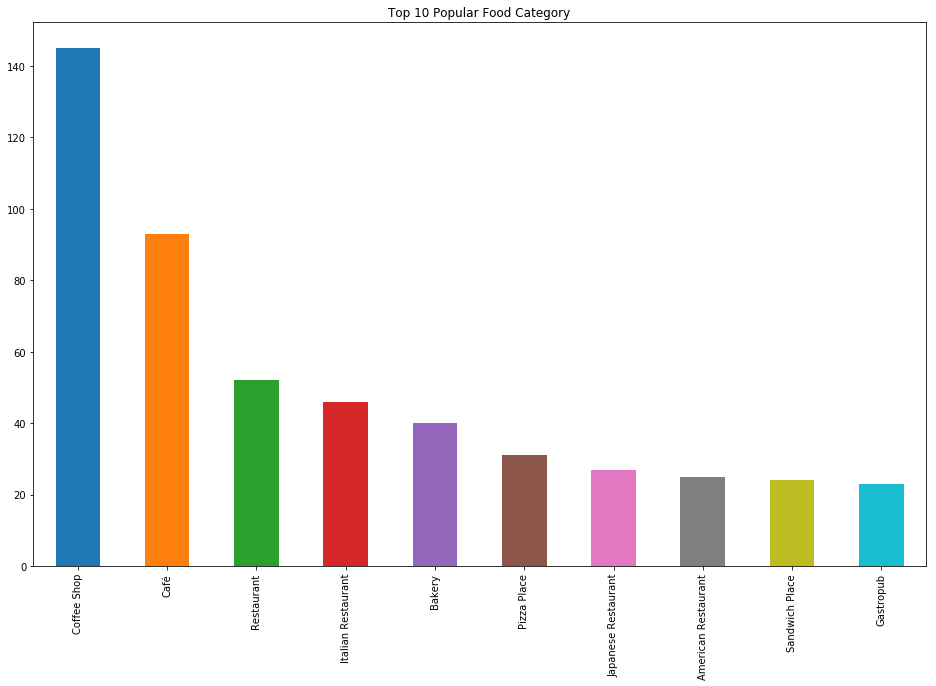

In [27]:
top_food_venues[:10].plot(kind='bar', figsize=(16, 10))

plt.title('Top 10 Popular Food Category')

1. Coffe is the most popolar venue category in Toronto. The top 2 categories: 'Coffee Shop' and 'Café', both serve coffee.
2. Cuisines like 'Italian', 'Bakery', 'Pizza' are also very popular, followed by 'Japanese' and 'Sandwich'.

In [28]:
food_onehot = pd.get_dummies(food_venues['Venue Category'])

food_onehot['Postcode'] = food_venues['Postcode']
food_onehot = food_onehot[[food_onehot.columns[-1]]+list(food_onehot.columns[:-1])]

food_onehot.head()

,Postcode,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,M4K,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M4K,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M4K,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M4K,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,M4K,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
food_grouped = food_onehot.groupby('Postcode').mean().reset_index() 
food_grouped.head()

,Postcode,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,M4K,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.033333,0.0,0.033333,0.000000,0.133333,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.3,0.0,0.066667,0.033333,0.0,0.100000,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,M4L,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.100000,0.1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.100000,0.000000,0.0,0.100000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.100000,0.000000,0.0,0.0,0.0,0.1,0.100000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,M4M,0.0,0.086957,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.173913,0.0,0.000000,0.043478,0.130435,0.0,0.043478,0.0,0.0,0.0,0.0,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.043478,0.000000,0.0,0.086957,0.0,0.0,0.000000,0.0,0.043478,0.0,0.0,0.0,0.000000,0.043478,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.043478,0.043478,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0
3,M4P,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,M4R,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.111111,0.0,0.111111,0.0,0.000000,0.111111,0.222222,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [30]:
food_clustering = food_grouped.drop('Postcode', axis=1)
food_clustering.head()

,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.033333,0.0,0.033333,0.000000,0.133333,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.3,0.0,0.066667,0.033333,0.0,0.100000,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.100000,0.1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.100000,0.000000,0.0,0.100000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.100000,0.000000,0.0,0.0,0.0,0.1,0.100000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.086957,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.173913,0.0,0.000000,0.043478,0.130435,0.0,0.043478,0.0,0.0,0.0,0.0,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.043478,0.000000,0.0,0.086957,0.0,0.0,0.000000,0.0,0.043478,0.0,0.0,0.0,0.000000,0.043478,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.043478,0.043478,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.111111,0.0,0.111111,0.0,0.000000,0.111111,0.222222,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [31]:
from sklearn.cluster import KMeans

food_distortions = []

for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(food_clustering)
    food_distortions.append(kmeans.inertia_)
    print(kmeans.labels_[:15])
    
food_distortions

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
[0 0 4 2 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 3 1 1 1 1 1 1 1 1 1 1 1]
[0 2 2 4 2 2 2 2 2 2 2 2 2 2 2]
[3 7 3 0 1 3 1 3 3 1 3 3 3 3 3]
[10  5  9  4  9  9  2  9  9  2  9  9  9  9  9]
[9 6 0 3 0 0 0 0 0 0 0 0 0 0 0]
[10  6  2  7 12  6  2  2  2  2  2  2  2  2  2]
[12  7  4  3  1 13  1  4  4  1  4  4  4  4  4]
[ 0  9  2  4 11  2 12  2  2 14  2  2  2  2  2]


[4.112660051687964,
 3.128787831013405,
 2.360020078395683,
 1.8801693769917205,
 1.5599093248296514,
 1.3666269852155524,
 1.1515953482657595,
 1.0566649234395498,
 0.9407204437957084,
 0.8301607514914118,
 0.7464217856699973,
 0.6779482211359299,
 0.6118979367929211,
 0.5061124089113079,
 0.4413042797449016]

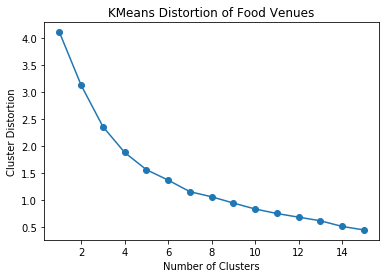

<Figure size 432x288 with 0 Axes>

In [54]:
plt.plot(range(1, 16), food_distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Distortion')
plt.title('KMeans Distortion of Food Venues')
plt.show()

In [33]:
k = 4

kmeans = KMeans(n_clusters=k, random_state=0).fit(food_clustering)

In [34]:
food_grouped.head()

,Postcode,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,M4K,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.033333,0.0,0.033333,0.000000,0.133333,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.3,0.0,0.066667,0.033333,0.0,0.100000,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,M4L,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.100000,0.1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.100000,0.000000,0.0,0.100000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.100000,0.000000,0.0,0.0,0.0,0.1,0.100000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,M4M,0.0,0.086957,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.173913,0.0,0.000000,0.043478,0.130435,0.0,0.043478,0.0,0.0,0.0,0.0,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.043478,0.000000,0.0,0.086957,0.0,0.0,0.000000,0.0,0.043478,0.0,0.0,0.0,0.000000,0.043478,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.043478,0.043478,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0
3,M4P,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,M4R,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.111111,0.0,0.111111,0.0,0.000000,0.111111,0.222222,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [56]:
columns = ['Postcode']
num_col = 5
for i in range(num_col):
    columns.append('#{} Food Venue'.format(i+1))

columns

['Postcode',
 '#1 Food Venue',
 '#2 Food Venue',
 '#3 Food Venue',
 '#4 Food Venue',
 '#5 Food Venue']

In [57]:
food_venues_sorted = pd.DataFrame(columns=columns)

food_venues_sorted['Postcode'] = food_grouped['Postcode']

In [58]:
for i in range(food_grouped.shape[0]):
    food_venues_sorted.iloc[i, 1:] = food_grouped.iloc[i, 1:].sort_values(ascending=False)[:num_col].index.values
    
food_venues_sorted

,Postcode,#1 Food Venue,#2 Food Venue,#3 Food Venue,#4 Food Venue,#5 Food Venue
0,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bubble Tea Shop
1,M4L,Pizza Place,Sushi Restaurant,Sandwich Place,Burger Joint,Fast Food Restaurant
2,M4M,Café,Coffee Shop,American Restaurant,Bakery,Italian Restaurant
3,M4P,Sandwich Place,Breakfast Spot,Wings Joint,Ethiopian Restaurant,Deli / Bodega
4,M4R,Coffee Shop,Burger Joint,Café,Diner,Mexican Restaurant
5,M4S,Dessert Shop,Pizza Place,Sandwich Place,Coffee Shop,Italian Restaurant
6,M4V,Coffee Shop,Pizza Place,Sushi Restaurant,Vietnamese Restaurant,Restaurant
7,M4X,Coffee Shop,Pizza Place,Café,Bakery,Italian Restaurant
8,M4Y,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Mediterranean Restaurant
9,M5A,Coffee Shop,Bakery,Café,Mexican Restaurant,Breakfast Spot


In [59]:
food_venues_sorted.insert(0, 'Cluster', kmeans.labels_)

In [60]:
food_merged = pd.merge(toronto_postcode, food_venues_sorted, how='right', left_on='Postcode', right_on='Postcode')
food_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,#1 Food Venue,#2 Food Venue,#3 Food Venue,#4 Food Venue,#5 Food Venue
0,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bubble Tea Shop
1,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,Pizza Place,Sushi Restaurant,Sandwich Place,Burger Joint,Fast Food Restaurant
2,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,American Restaurant,Bakery,Italian Restaurant
3,M4P,Central Toronto,Davisville North,43.712751,-79.390197,3,Sandwich Place,Breakfast Spot,Wings Joint,Ethiopian Restaurant,Deli / Bodega
4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,0,Coffee Shop,Burger Joint,Café,Diner,Mexican Restaurant


## All area in Toronto are Grouped into 4 Clusters Based on Food Venues

In [61]:
food_merged = food_merged.sort_values(by='Cluster')

### Cluster 0

In [62]:
food_merged[food_merged['Cluster']==0]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,#1 Food Venue,#2 Food Venue,#3 Food Venue,#4 Food Venue,#5 Food Venue
0,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bubble Tea Shop
30,M6R,West Toronto,"Roncesvalles, Parkdale",43.648960,-79.456325,0,Breakfast Spot,Cuban Restaurant,Dessert Shop,Coffee Shop,Italian Restaurant
29,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,0,Café,Mexican Restaurant,Fried Chicken Joint,Gastropub,Thai Restaurant
28,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,0,Coffee Shop,Breakfast Spot,Café,Burrito Place,Bakery
27,M6J,West Toronto,"Trinity, Little Portugal",43.647927,-79.419750,0,Asian Restaurant,Coffee Shop,Pizza Place,French Restaurant,Vietnamese Restaurant
26,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259,0,Bakery,Middle Eastern Restaurant,Café,Wings Joint,Ethiopian Restaurant
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0,Café,Diner,Coffee Shop,Italian Restaurant,Restaurant
24,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0,Coffee Shop,Café,Restaurant,Steakhouse,Burger Joint
23,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,0,Coffee Shop,Italian Restaurant,Café,Restaurant,Seafood Restaurant
21,M5T,Downtown Toronto,"Grange Park, Kensington Market, Chinatown",43.653206,-79.400049,0,Café,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Chinese Restaurant,Vietnamese Restaurant


### Cluster 1

In [63]:
food_merged[food_merged['Cluster']==1]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,#1 Food Venue,#2 Food Venue,#3 Food Venue,#4 Food Venue,#5 Food Venue
18,M5P,Central Toronto,"Forest Hill West, Forest Hill North",43.696948,-79.411307,1,Sushi Restaurant,Wings Joint,Ethiopian Restaurant,Deli / Bodega,Dessert Shop


### Cluster 2

In [64]:
food_merged[food_merged['Cluster']==2]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,#1 Food Venue,#2 Food Venue,#3 Food Venue,#4 Food Venue,#5 Food Venue
22,M5V,Downtown Toronto,"Bathurst Quay, Harbourfront West, Island airpo...",43.628947,-79.39442,2,Coffee Shop,Wings Joint,Cupcake Shop,Dessert Shop,Dim Sum Restaurant


### Cluster 3

In [65]:
food_merged[food_merged['Cluster']==3]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster,#1 Food Venue,#2 Food Venue,#3 Food Venue,#4 Food Venue,#5 Food Venue
3,M4P,Central Toronto,Davisville North,43.712751,-79.390197,3,Sandwich Place,Breakfast Spot,Wings Joint,Ethiopian Restaurant,Deli / Bodega


In [45]:
# create map
map_clusters = folium.Map(location=[tor_lat, tor_lng], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(food_merged['Latitude'], food_merged['Longitude'], food_merged['Postcode'], 
                                  food_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [55]:
map_clusters.save('map_clusters.html')

All food venues in Toronto are grouped into 4 clusters. Cluster 0 consists of 'Coffee Shop' and 'Café'. Cluster 1, 2 and 3 are restaurant clusters and the popoular cuisines are different in these three clusters. Restaurants are most popular in Cluster 1, while Sushi Restaurants most popular in Cluser 2 and Coffee Shop most popular in Cluster 3. Wings Joints are very popular in these three clusters.